In [1]:
library(fpp3)
library(latex2exp)

── Attaching packages ────────────────────────────────────────────── fpp3 0.3 ──
✔ tibble      3.1.2      ✔ tsibble     0.9.3 
✔ dplyr       1.0.7      ✔ tsibbledata 0.2.0 
✔ tidyr       1.1.3      ✔ feasts      0.1.6 
✔ lubridate   1.7.10     ✔ fable       0.2.1 
✔ ggplot2     3.3.3      
── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()   masks base::date()
✖ dplyr::filter()     masks stats::filter()
✖ tsibble::interval() masks lubridate::interval()
✖ dplyr::lag()        masks stats::lag()


# 1.

Because there are 

In [2]:
length(unique(global_economy$Country))

[1] 263

countries, this is too much too plot. Instead, I will plot for the country with the highest GDP per Capita at the most recent date.

In [3]:
top_gdp_capita <- global_economy %>%
    drop_na(GDP, Population) %>% #so we don't get NA's
    mutate(GDPpC = GDP/Population) %>% #calculate gdp per capita
    filter(Year == max(Year)) %>% #get most recent year
    filter(GDPpC == max(GDPpC)) #get highest gdp per capita

The country with the highest GDP per capita is

In [4]:
toString(top_gdp_capita$Country)

[1] "Luxembourg"

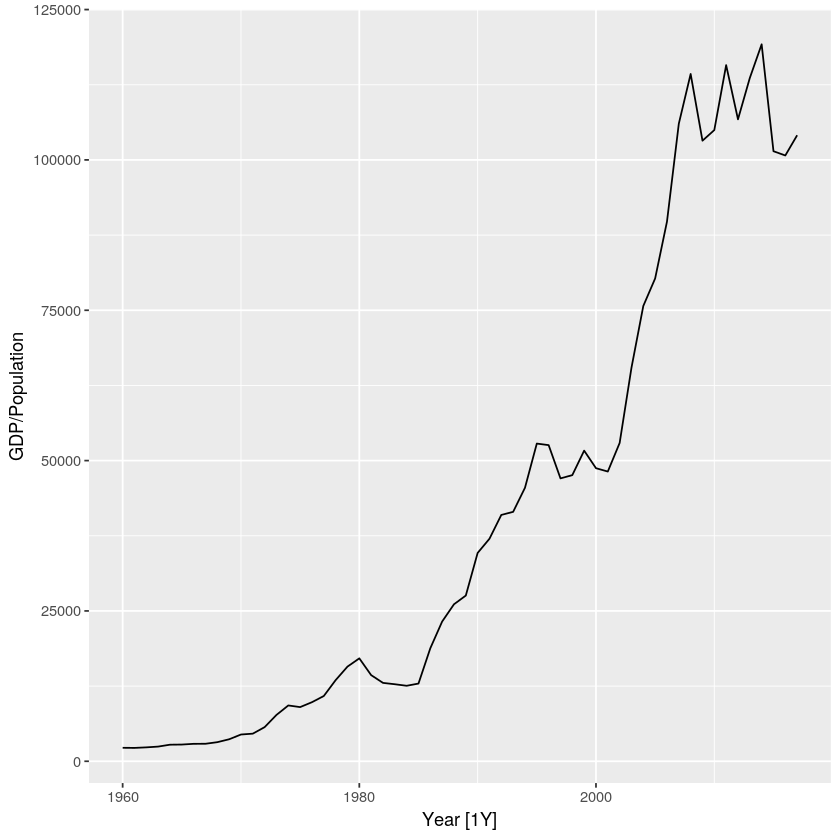

In [5]:
global_economy %>%
    filter(Country == "Luxembourg") %>%
    autoplot(GDP/Population)

The GDP per Capita of Luxembourg, began rising very modestly from 1960 through the mid-1980's before experiencing a high rate of growth up until the mid-1990's. From the mid-1990's till the early 2000's the GDP per capita did not seem to grow much at all. Then from the early 2000's to the late 2000's, rapid growth in GDP per capita occured once again before levelling off in more recent years.

# 2.

## United States GDP from `global_economy`.

In [6]:
us_economy <- global_economy %>%
    filter(Country == "United States")

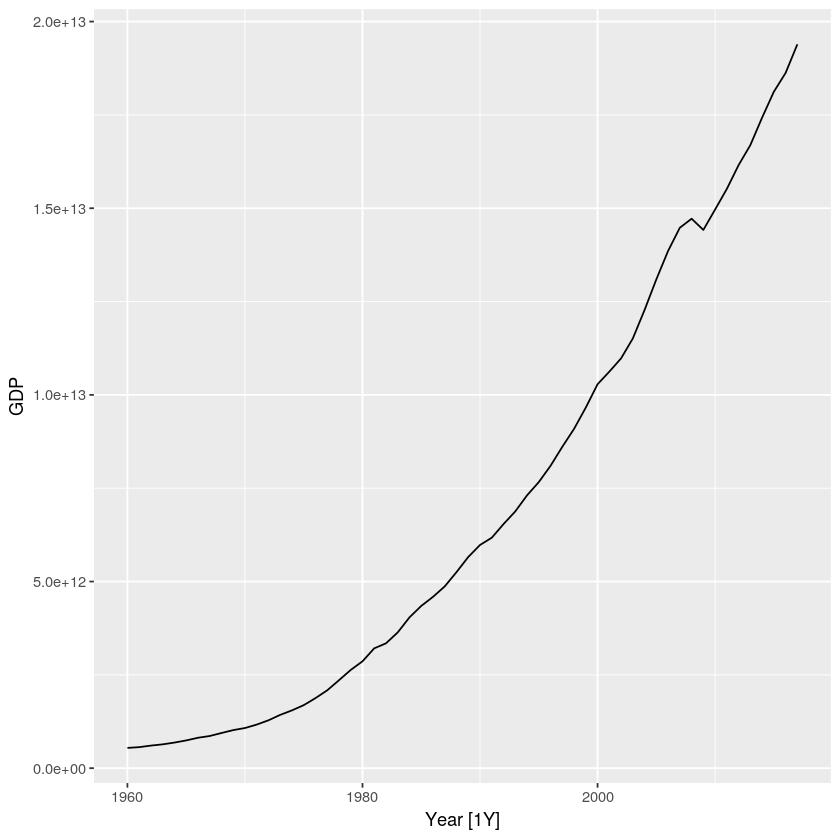

In [7]:
us_economy %>%
    autoplot(GDP)

Because GDP is heavily affected by population (more people can produce more wealth), we will look at GDP per capita instead.

In [8]:
us_economy <- us_economy %>%
    mutate(GDPpC = GDP/Population)

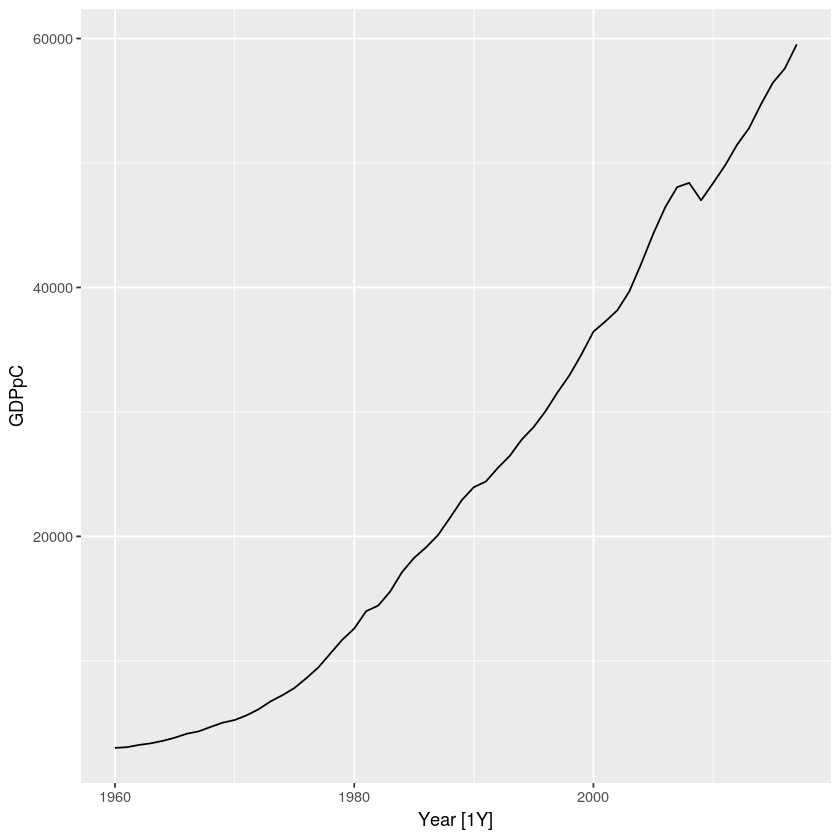

In [9]:
us_economy %>%
    autoplot(GDPpC)

While GDP per Capita for the United States has the same shape as GDP, it gives a better picture of the overall wealth in that country.

## Slaughter of Victorian "Bulls, bullocks and steers" in `aus_livestock`.

In [10]:
unique(aus_livestock$State)

[1] Australian Capital Territory New South Wales             
[3] Northern Territory           Queensland                  
[5] South Australia              Tasmania                    
[7] Victoria                     Western Australia           
8 Levels: Australian Capital Territory New South Wales ... Western Australia

In [11]:
bbs <- aus_livestock %>%
    filter(State == "Victoria", Animal == "Bulls, bullocks and steers")

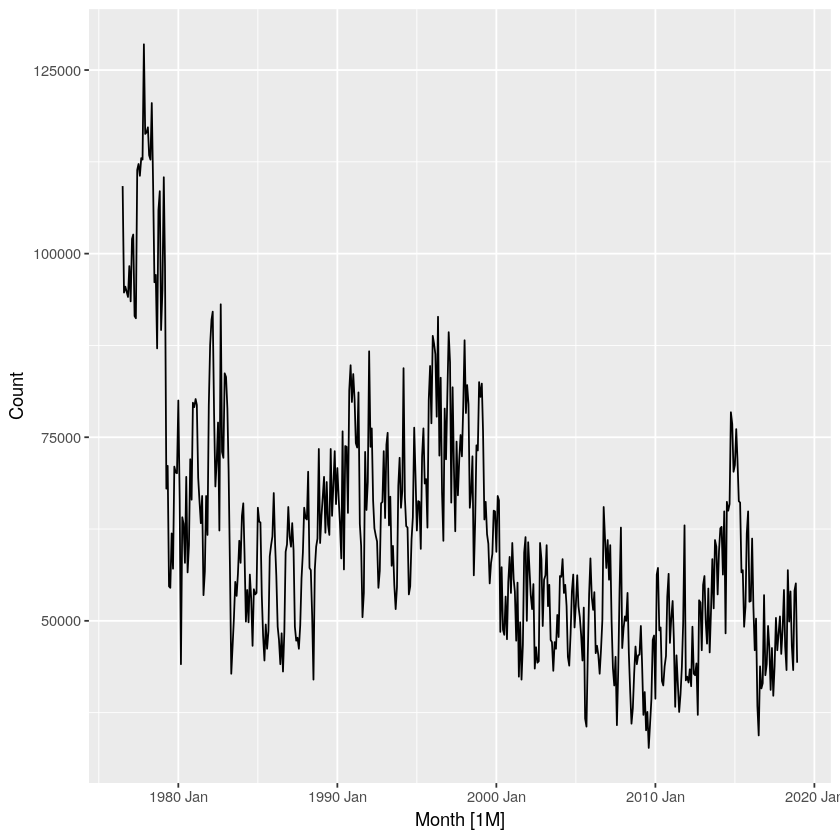

In [12]:
bbs %>%
    autoplot(Count)

In observing the above series, aside from the steep drop in `Count` at the end of the 1970's, the variance is quite stable and doesn't seem to increase or decrease with the level of the series. Given this, I don't think a transformation is needed.

## Victorian Electricity Demand from `vic_elec`.

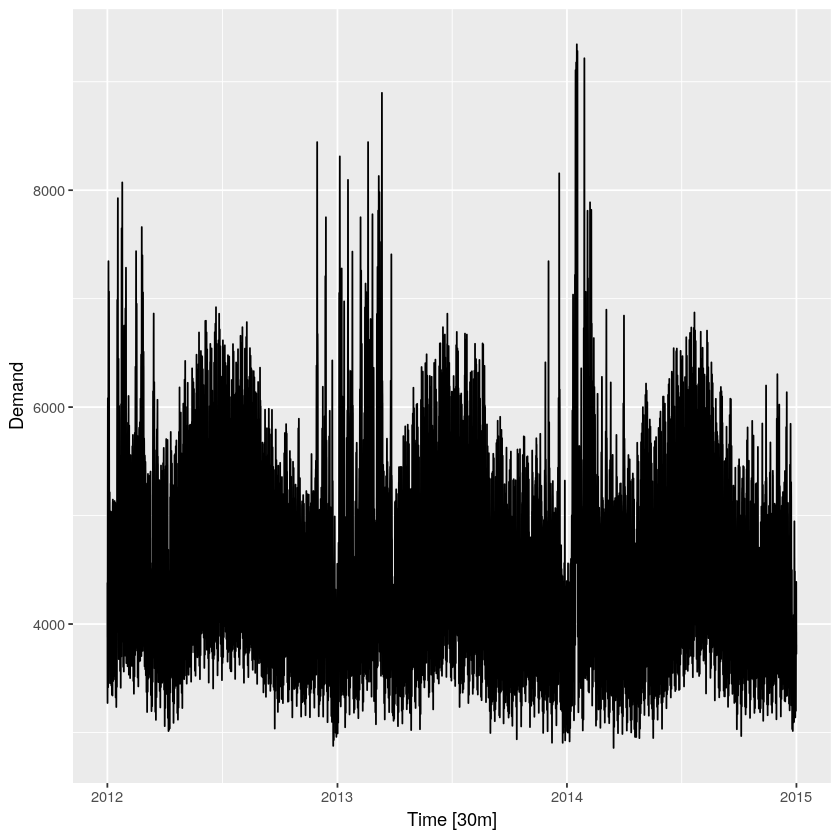

In [13]:
vic_elec %>%
    autoplot(Demand)

Over the long-run, the variance appears fairly stable and does not seem to increase of decrease with the level of the series, so I don't think a transformation is needed.

## Gas production from `aus_production`.

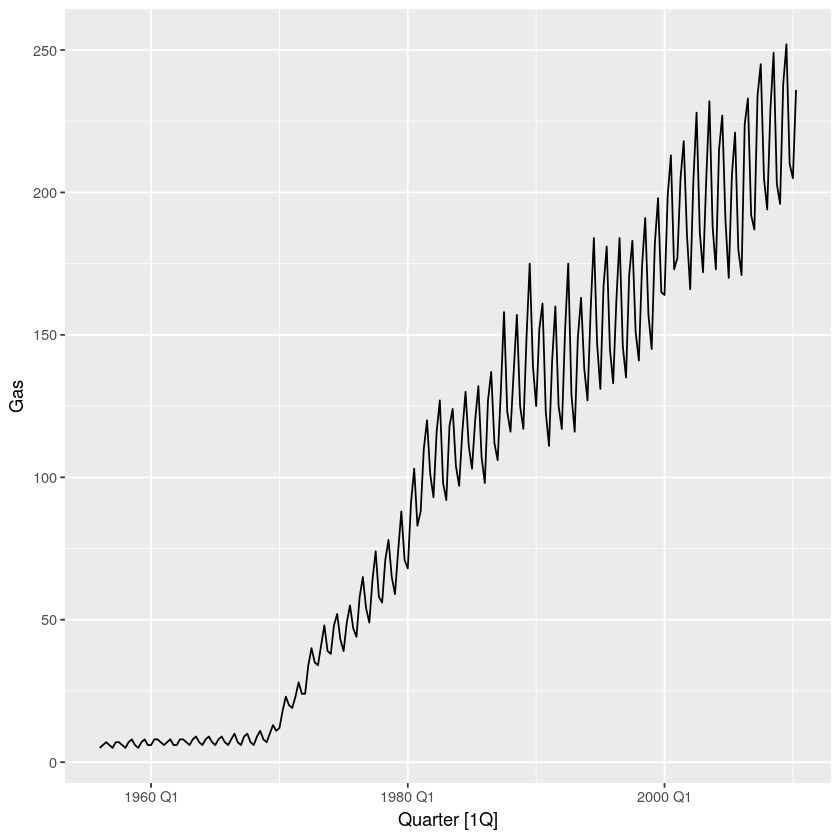

In [14]:
aus_production %>%
    autoplot(Gas)

In the above plot, we can see clearly that the variance increases with the level of the series. Given this, a mathematical transformation to stabilize the variance is needed if we would like to model this data with an additive decompositon.

The mathematical transformation we will use here will the box-cox transformation with $\lambda$ chosen using the `guerrero` feature.

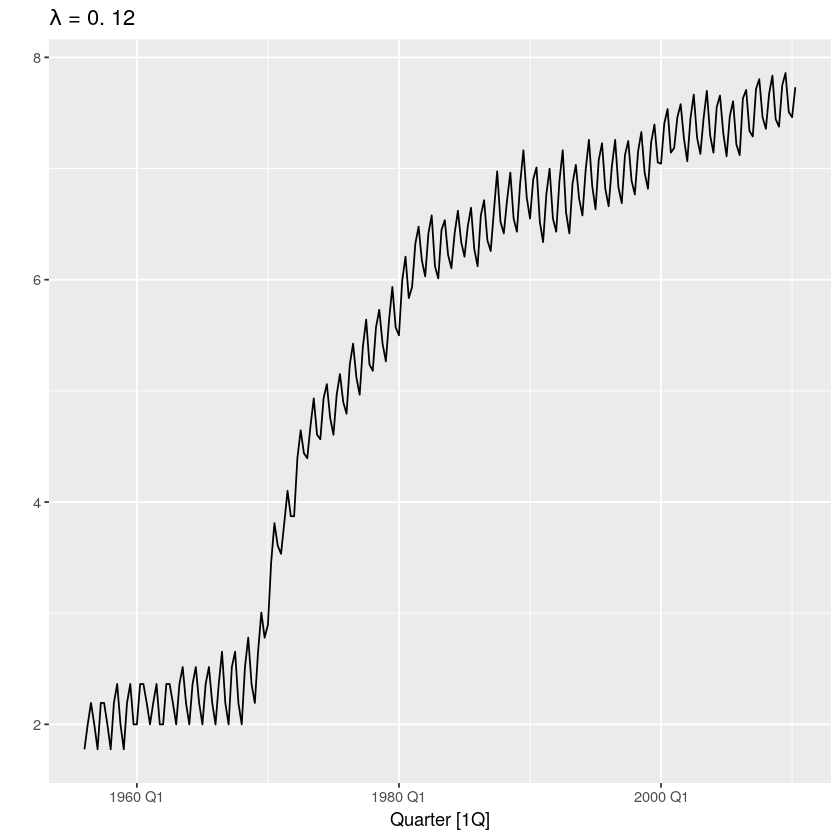

In [15]:
lambda <- aus_production %>%
  features(Gas, features = guerrero) %>%
  pull(lambda_guerrero)
aus_production %>%
  autoplot(box_cox(Gas, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
          "$\\lambda$ = ", 
           round(lambda,2))))

As we can see in the plot above, the transformed data variance no longer seems to increase as much with the level of the series.

# 3.

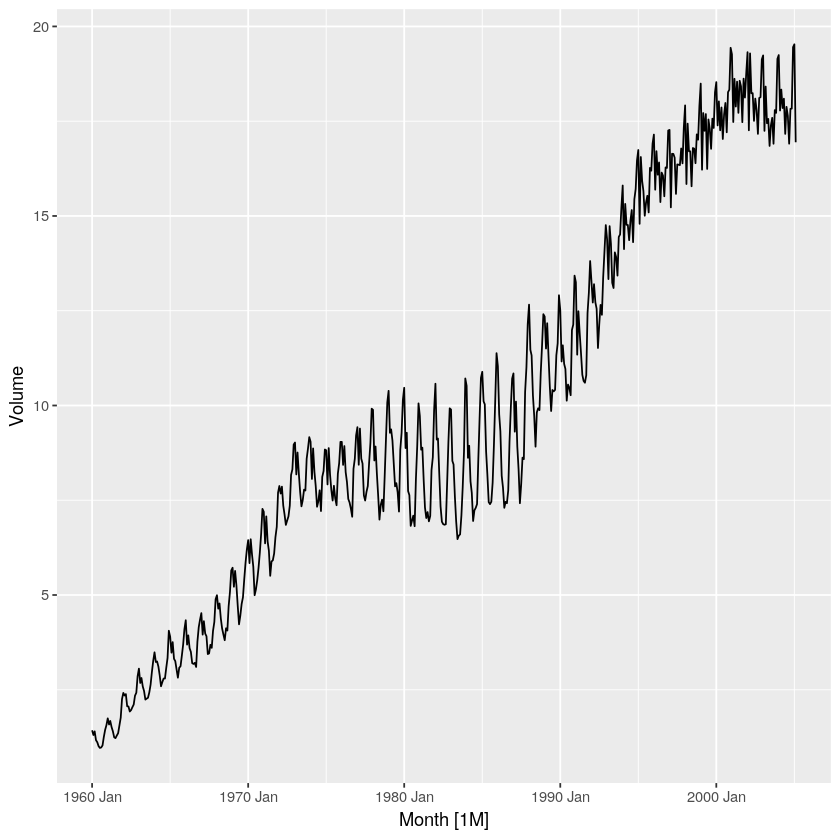

In [16]:
canadian_gas %>%
    autoplot(Volume)

While the variance is not stable throughout the series entire series (stable in the beginning and the end but not in the middle), it also doesn't seem to either increase or decrease over time. The reason this is important to note is that box-cox transformations can only properly stabilize the variance of the data if the data's variance is either increasing or decreasing overall with time, not if the variance both increases *and* decreases at varying points in the series.

To prove the point that a box-cox transformation can't stabilize this series variance (even with an optimal value of $\lambda$) we will attempt to do just that.

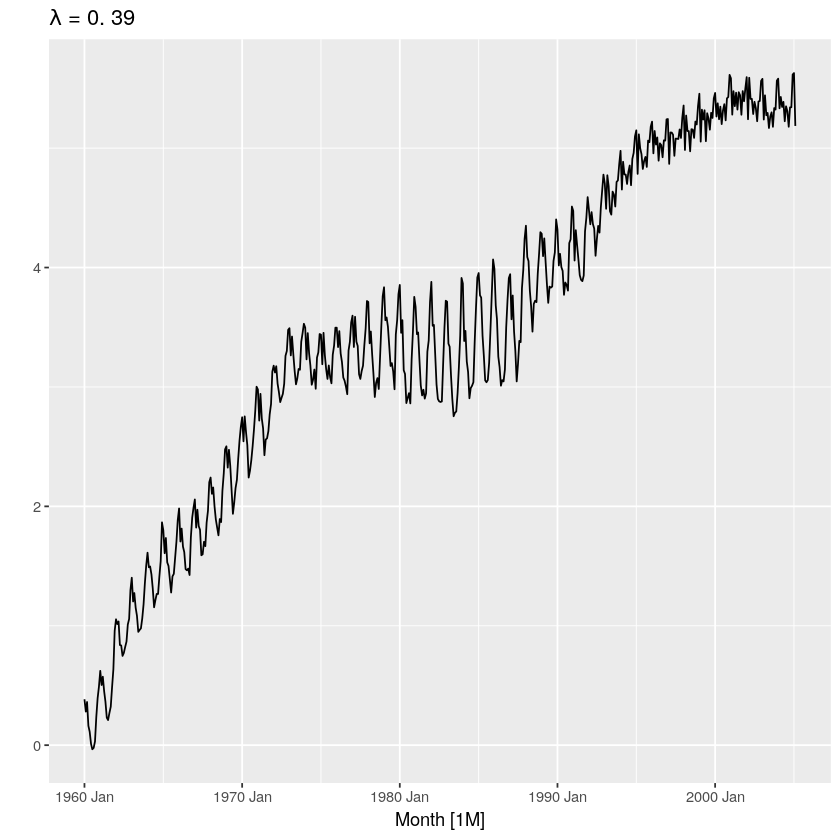

In [17]:
lambda <- canadian_gas %>%
  features(Volume, features = guerrero) %>%
  pull(lambda_guerrero)
canadian_gas %>%
  autoplot(box_cox(Volume, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
          "$\\lambda$ = ", 
           round(lambda,2))))

As we can see, a Box-Cox transformation was indeed unhelpful for the `canadian_gas` data.

# 4.

In [18]:
set.seed(2021)
myseries <- aus_retail %>%
  filter(`Series ID` == sample(aus_retail$`Series ID`,1))

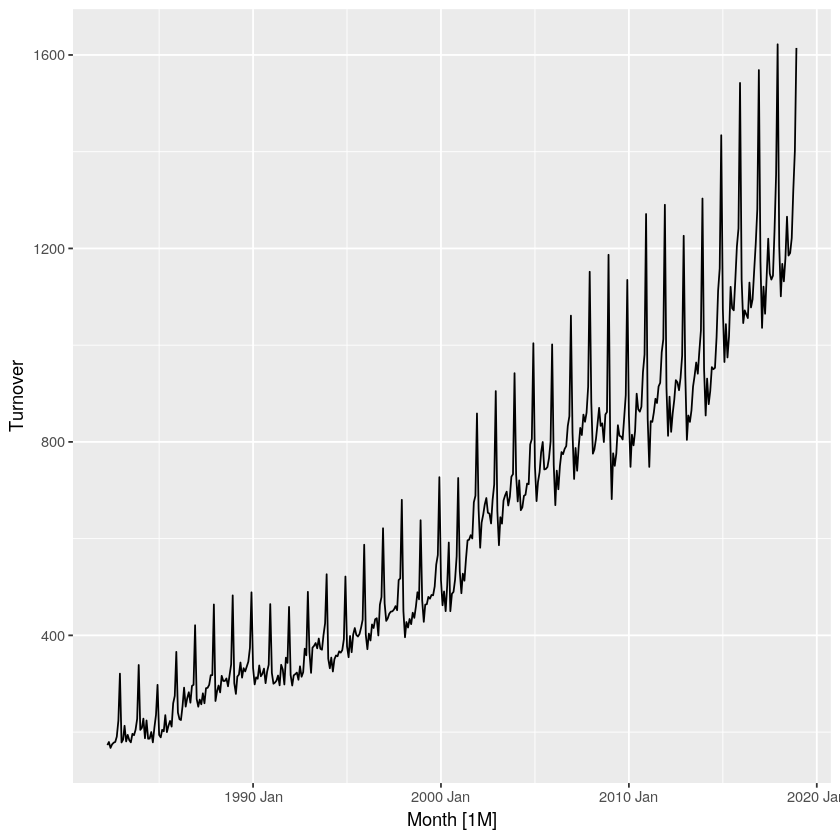

In [19]:
myseries %>%
    autoplot(Turnover)

To decide which Box-Cox transformation to use, I will select $\lambda$ using the guerrero feature.

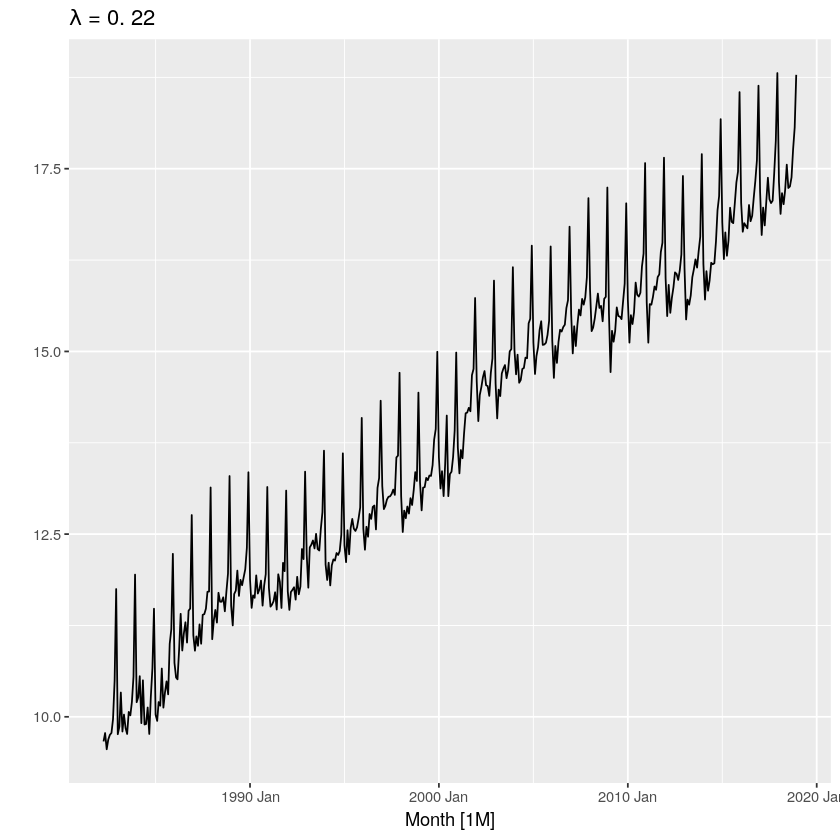

In [20]:
lambda <- myseries %>%
  features(Turnover, features = guerrero) %>%
  pull(lambda_guerrero)
myseries %>%
  autoplot(box_cox(Turnover, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
          "$\\lambda$ = ", 
           round(lambda,2))))

For my retail data, I would use the power transformation corresponding to a Box-Cox transformation with $\lambda=0.22$.

# 5.

In each of the Box-Cox transformations below, I will be using the Guerrero feature to find the 'optimal' value for $\lambda$. I realize that I could manually try to determine which value of $\lambda$ to use, but I'm lazy :P

## Tobacco from `aus_production`

### Before Transformation:

Warning message:
“Removed 24 row(s) containing missing values (geom_path).”

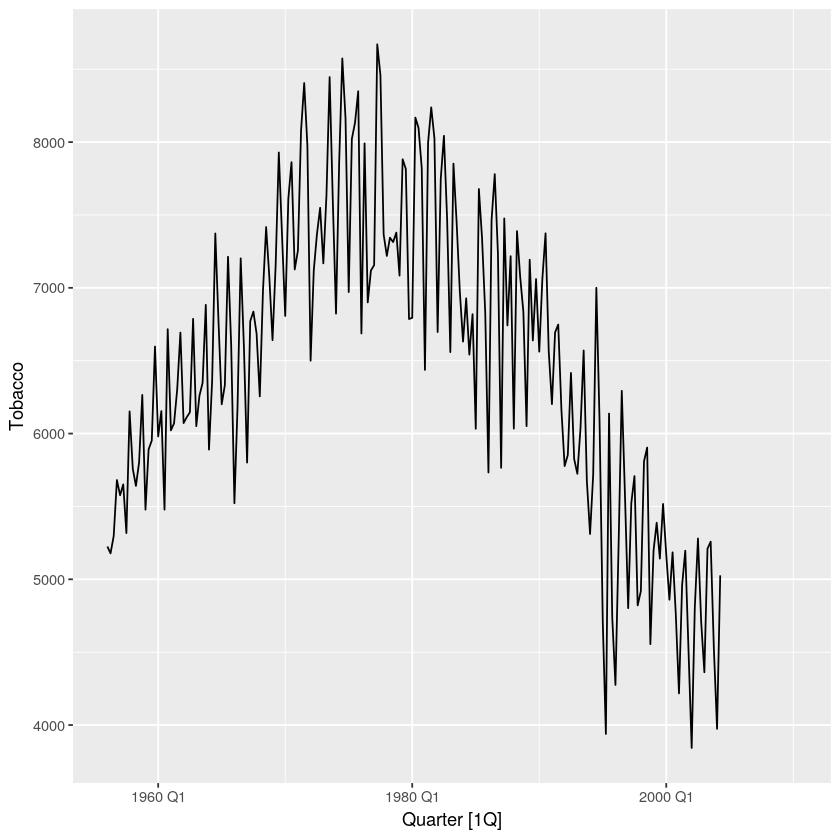

In [21]:
aus_production %>%
    autoplot(Tobacco)

### After Transformation:

Warning message:
“Removed 24 row(s) containing missing values (geom_path).”

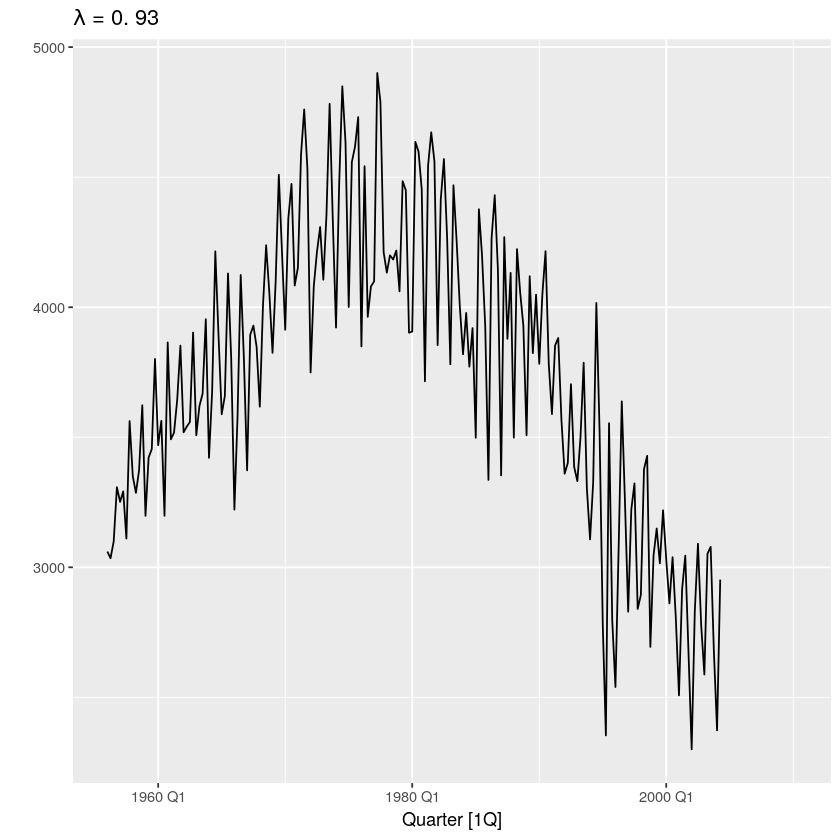

In [22]:
lambda <- aus_production %>%
  features(Tobacco, features = guerrero) %>%
  pull(lambda_guerrero)
aus_production %>%
  autoplot(box_cox(Tobacco, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
          "$\\lambda$ = ", 
           round(lambda,2))))

Box-Cox transformation with $\lambda=0.93$.

## Economy class passengers betwen Melbourne and Sydney from `ansett`

In [23]:
#economy melbourne sydney
e_ms <- ansett %>%
    filter(Class == "Economy", Airports == "MEL-SYD")

### Before Transformation:

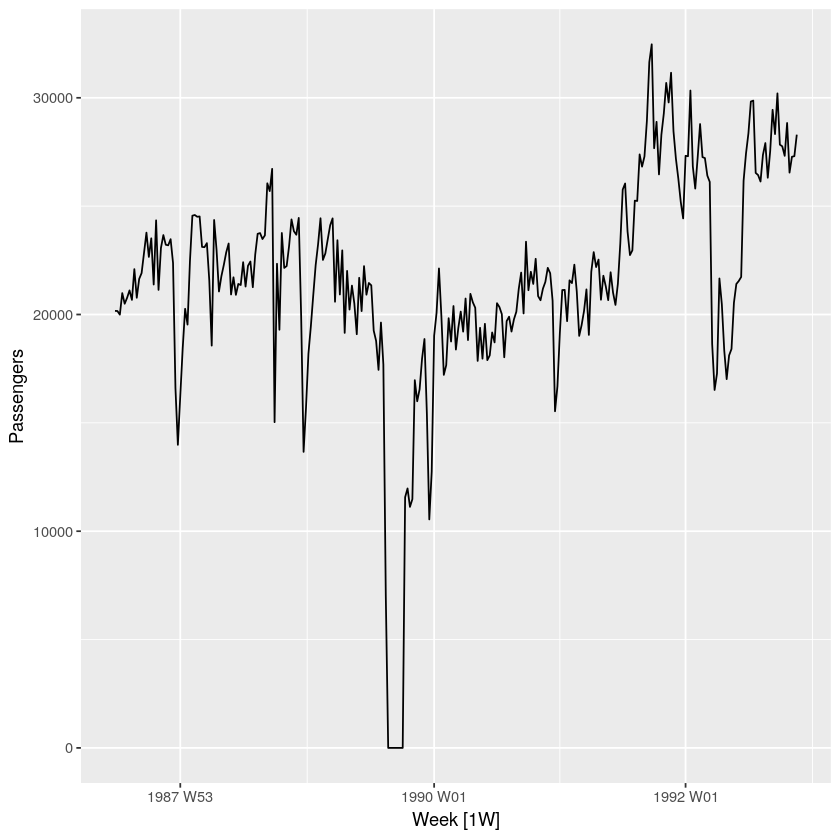

In [24]:
e_ms %>%
    autoplot(Passengers)

### After Transformation:

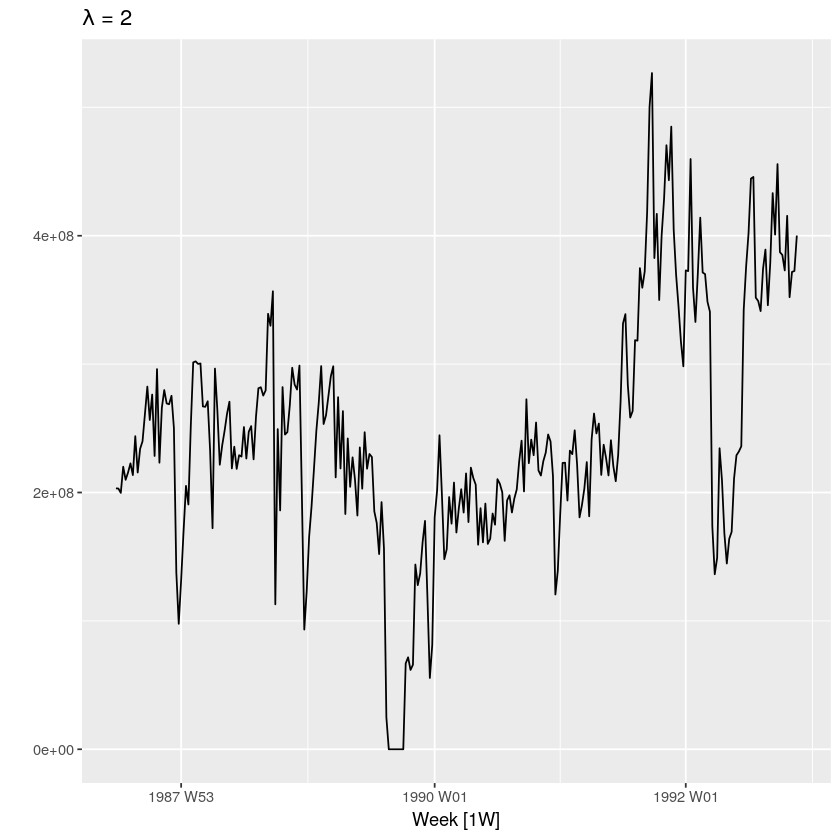

In [25]:
lambda <- e_ms %>%
  features(Passengers, features = guerrero) %>%
  pull(lambda_guerrero)
e_ms %>%
  autoplot(box_cox(Passengers, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
          "$\\lambda$ = ", 
           round(lambda,2))))

Box-Cox transformation with $\lambda=2$.

## Pedestrian counts at Southern Cross Station from `pedestrian`

In [26]:
#southern cross station
scs <- pedestrian %>%
    filter(Sensor == "Southern Cross Station")

### Before Transformation:

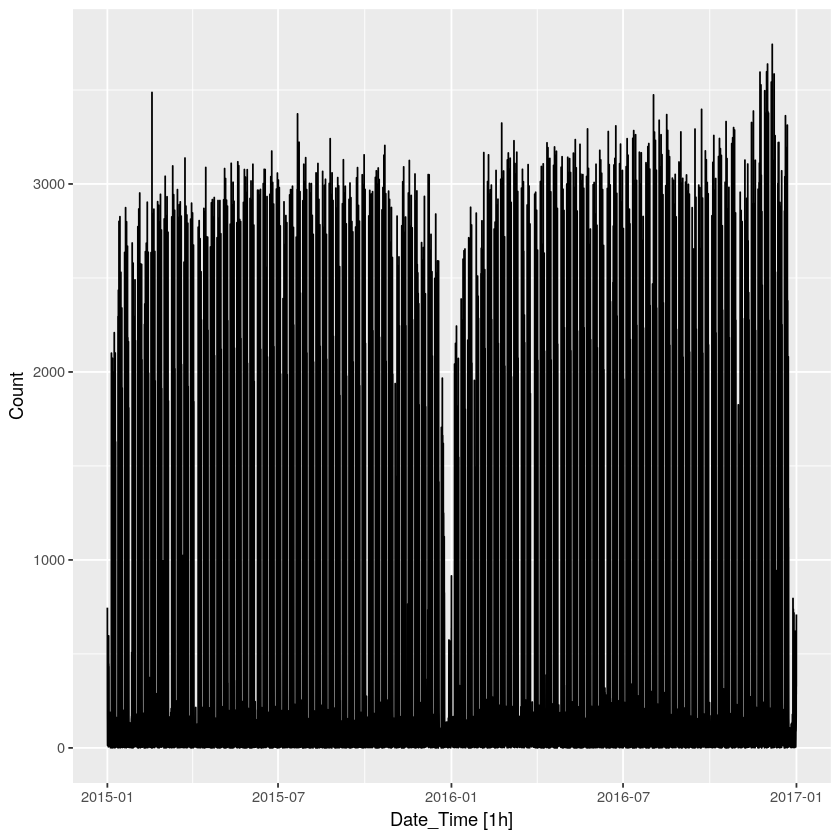

In [27]:
scs %>%
    autoplot(Count)

### After Transformation:

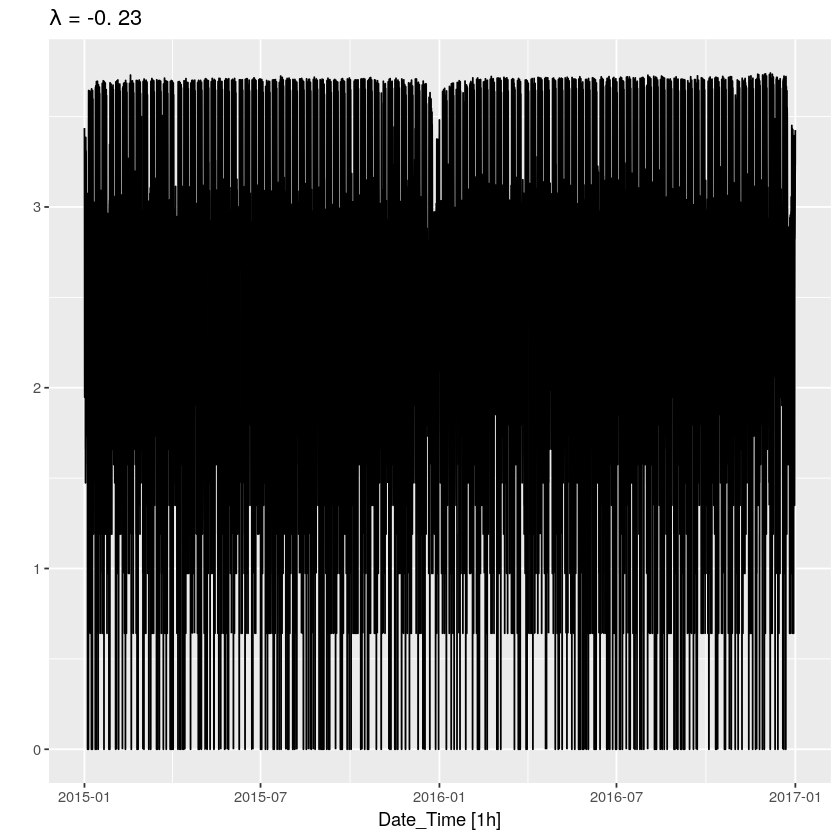

In [28]:
lambda <- scs %>%
  features(Count, features = guerrero) %>%
  pull(lambda_guerrero)
scs %>%
  autoplot(box_cox(Count, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
          "$\\lambda$ = ", 
           round(lambda,2))))

Box-Cox transformation with $\lambda=-0.23$.

# 6.

${\large \hat{T}_t= \frac{1}{3} [} 
\frac{1}{5}(y_{t-3}+y_{t-2}+y_{t-1}+y_{t}+y_{t+1})   
+ \frac{1}{5}(y_{t-2}+y_{t-1}+y_{t}+y_{t+1}+y_{t+2})
+ \frac{1}{5}(y_{t-1}+y_{t}+y_{t+1}+y_{t+2}+y_{t+3}){\large]}$

$\Rightarrow {\large \hat{T}_t= \frac{1}{15} [} 
\frac{1}{5}y_{t-3}+2\cdot y_{t-2}+3\cdot y_{t-1}+3\cdot y_{t}+3\cdot y_{t+1}+2\cdot y_{t+2}+y_{t+3} {\large]}$

$\Rightarrow {\large \hat{T}_t}=  
0.067\cdot y_{t-3}+0.133\cdot y_{t-2}+0.2\cdot y_{t-1}+0.2\cdot y_{t}+0.2\cdot y_{t+1}+0.133\cdot y_{t+2}+0.067\cdot y_{t+3}$

# 7.

In [29]:
#5 years, 4 quarters
gas <- tail(aus_production, 5*4) %>% select(Gas)

## a.

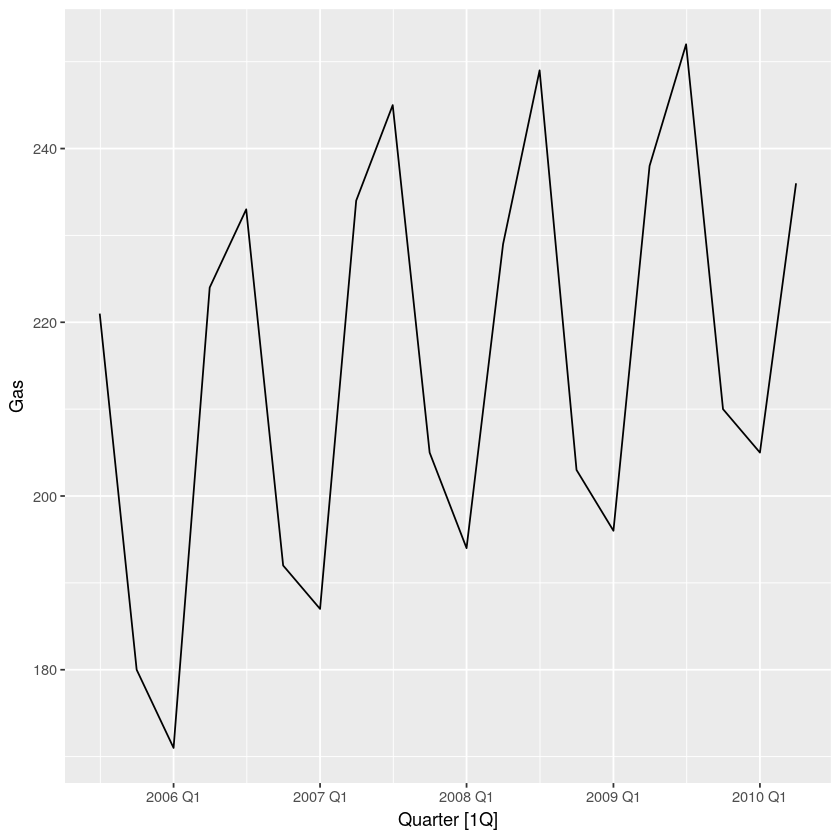

In [30]:
gas %>%
    autoplot(Gas)

Above, we can see that there is a clear upward trend in Gas production from 2006 through 2010.

Warning message in NextMethod("["):
“Incompatible methods (">=.Date", ">=.vctrs_vctr") for ">="”Warning message in NextMethod("["):
“Incompatible methods ("<=.Date", "<=.vctrs_vctr") for "<="”Warning message in NextMethod("["):
“Incompatible methods (">=.Date", ">=.vctrs_vctr") for ">="”Warning message in NextMethod("["):
“Incompatible methods ("<=.Date", "<=.vctrs_vctr") for "<="”

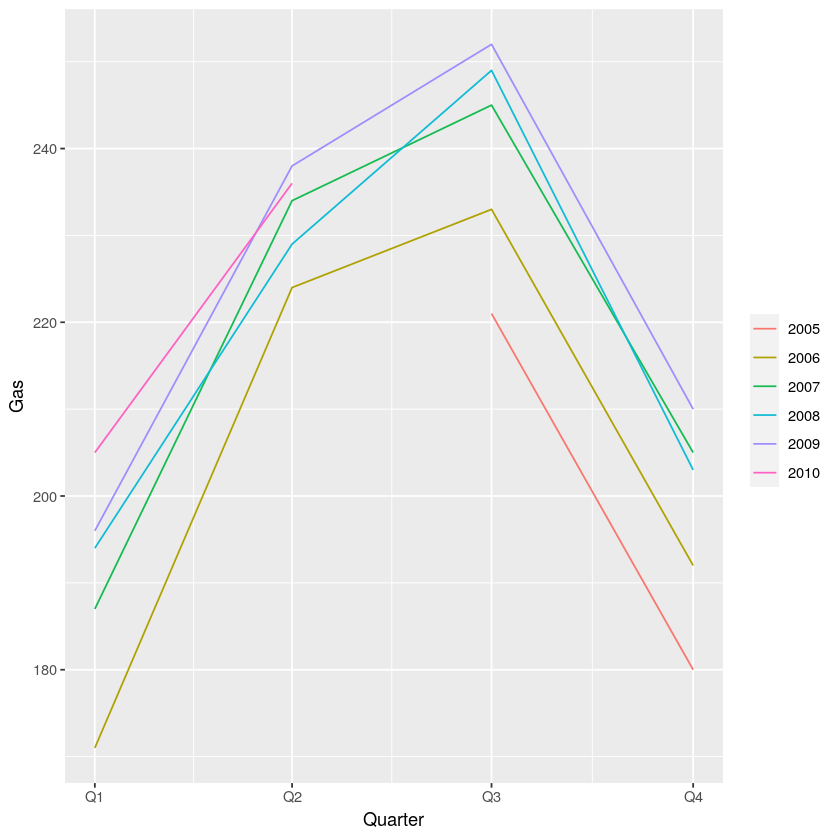

In [31]:
#data seems to be incomplete, but that's okay
gas %>%
    gg_season(Gas)

From this plot, we can see that Gas production tends to be at it's lowest in the first quarter, rises into the second quarter before peaking in the third quarter, then falling again in the fourth quarter.

## b.

In [32]:
dcmp <- gas %>%
    model(classical_decomposition(Gas, type = "multiplicative"))

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”

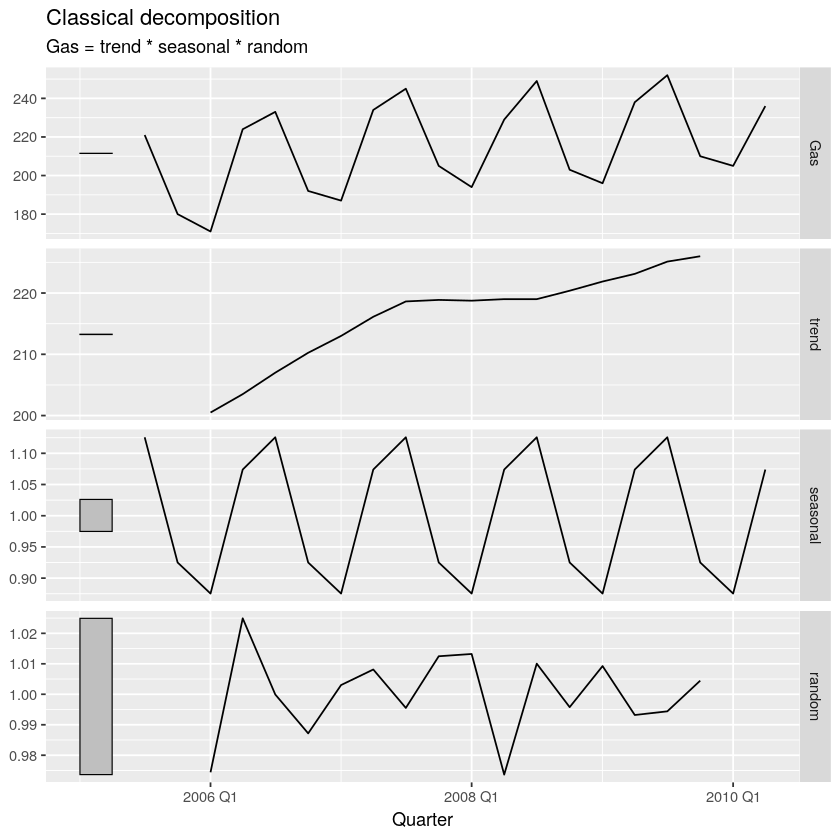

In [33]:
components(dcmp) %>%
    autoplot()

## c.

Yes. We can see from the decomposition from **b.** that, there is a clear upward trend and also a seasonal component that follows the pattern described in **a.**.

## d.

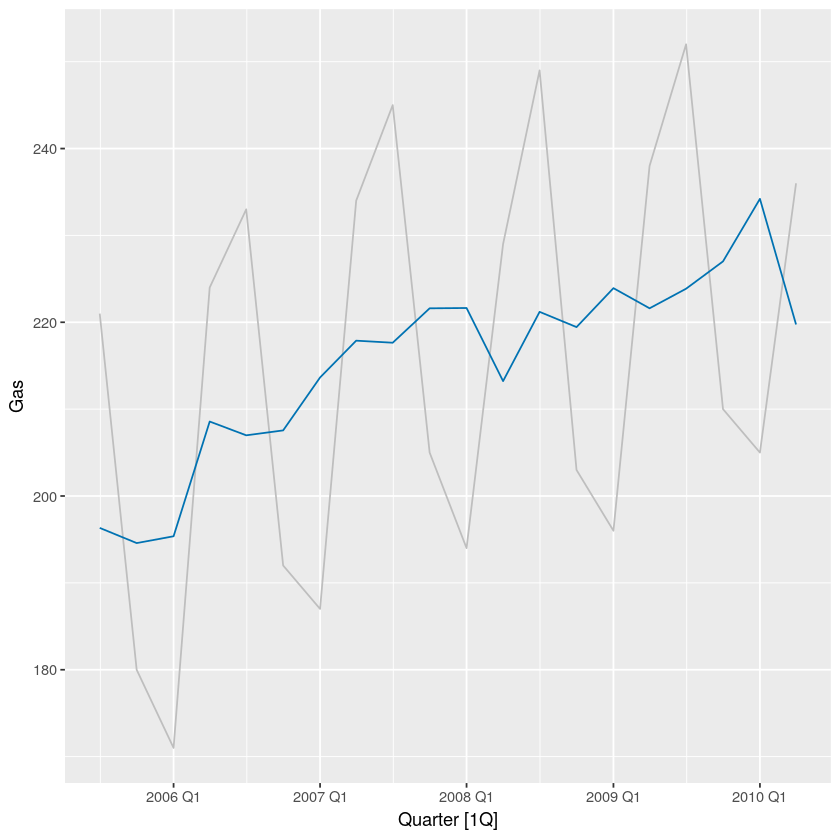

In [34]:
components(dcmp) %>%
    as_tsibble() %>%
    autoplot(Gas, colour = "gray") + 
    geom_line(aes(y=season_adjust), colour = "#0072B2")

## e.

In [35]:
#create a copy of the data that we can add the outlier to
gas_outlier_mid = as_tsibble(gas)

#create an outlier of +300 at the 10'th index of the series
outlier_mid <- rep(0,length(gas$Gas))
outlier_mid[10] = 300

#add the outlier
gas_outlier_mid$Gas = gas_outlier_mid$Gas + outlier_mid

In [36]:
#compute the decompositon of the new dataset
dcmp_outlier_mid <- gas_outlier_mid %>%
    model(classical_decomposition(Gas, type = "multiplicative"))

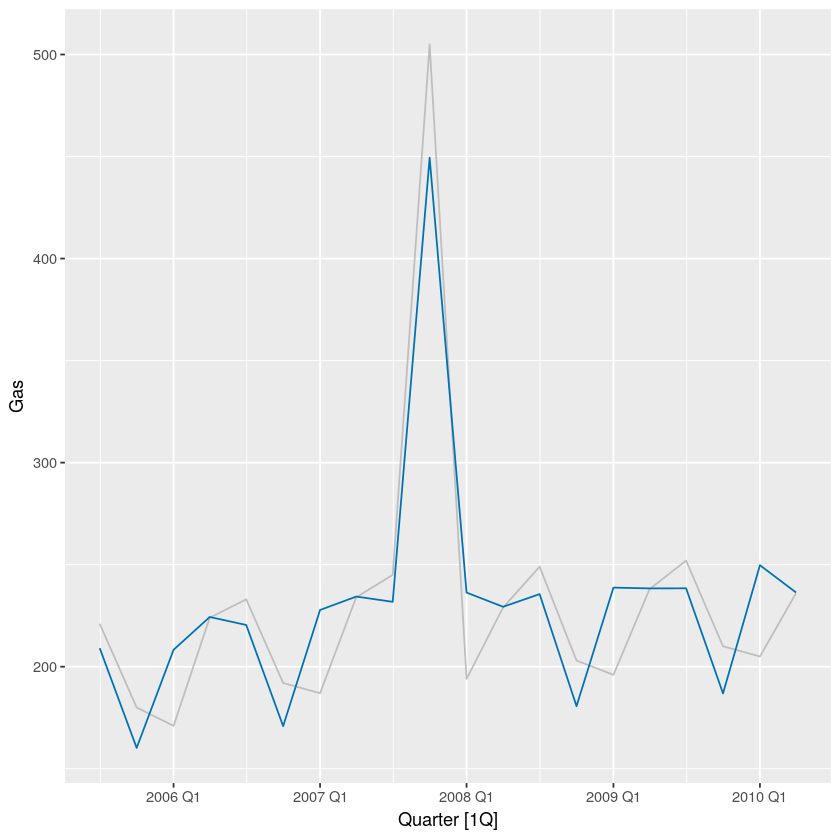

In [37]:
components(dcmp_outlier_mid) %>%
    as_tsibble() %>%
    autoplot(Gas, colour = "gray") + 
    geom_line(aes(y=season_adjust), colour = "#0072B2")

From the above plot, we can see that with the introduction of the outlier in the middle, the seasonally adjusted data is now more affected by the seasonality, defeating it's very purpose.

## f.

In the above question, we already added an outlier to the middle, so this time we will add one near the end.

In [38]:
#create a copy of the data that we can add the outlier to
gas_outlier_end = as_tsibble(gas)

#create an outlier of +300 at the 10'th index of the series
outlier_end <- rep(0,length(gas$Gas))
outlier_end[18] = 300

#add the outlier
gas_outlier_end$Gas = gas_outlier_end$Gas + outlier_end

In [39]:
#compute the decompositon of the new dataset
dcmp_outlier_end <- gas_outlier_end %>%
    model(classical_decomposition(Gas, type = "multiplicative"))

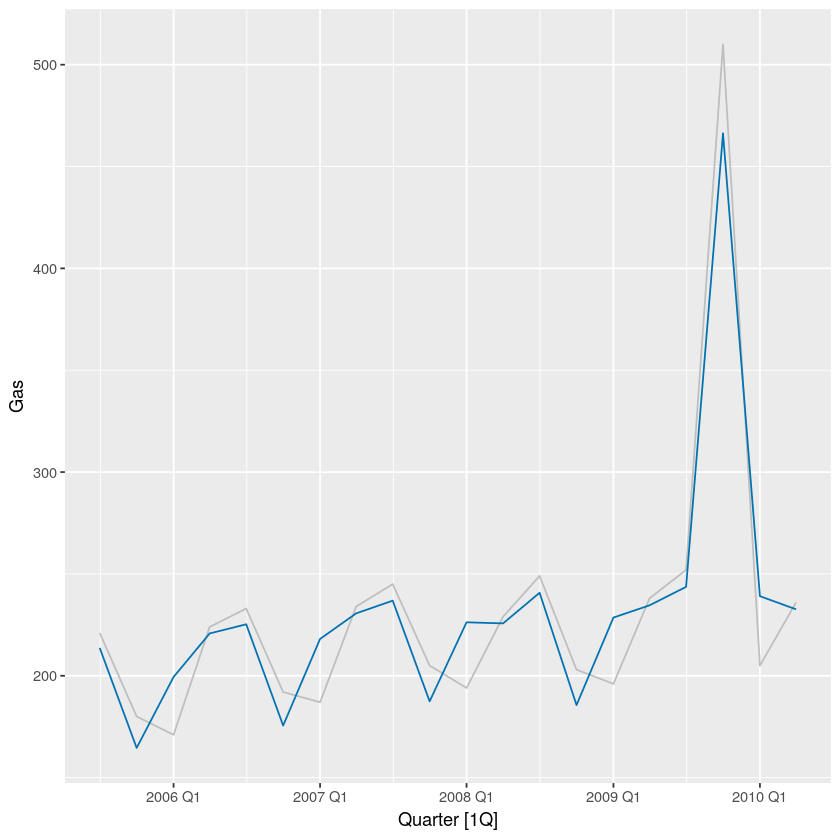

In [40]:
components(dcmp_outlier_end) %>%
    as_tsibble() %>%
    autoplot(Gas, colour = "gray") + 
    geom_line(aes(y=season_adjust), colour = "#0072B2")

Similarly to when the outlier was added to the middle, adding an outlier to the end seems to negatively affect the seasonally-adjusted datas' ability to adjust for seasonallity.

What's different in this plot, however, is that the seasonally-adjusted data now seems to conform more closely with the seasonal patterns of the data, perhapbs mistaking seasonallity for the trend-cycle.

# 8.

Uforturnately, I won't be answering this question. The installation and setup needed to be able to use X-11 or SEATS via X_13ARIMA_SEATS is quite complicated and requires the use of packages not covered in this book.

# 9.

# a.

Firstly, in observing the trend component, we can cleasrly see that there has been a steady rise in the number of people in the Australian civilian labour force over the years.

Secondly, we can see from observing the seasonal component - both in Figure 3.19 & 3.20 - that the seasonal pattern has changed over the years rather than staying the same.

Finally, in observing the remainder component, we can see that there was a brief dip down in the number of people in the labour force in 1991-1992. One thing that's interesting about this dip is that it's magnitude was much larger than the usual seasonal effect which means that it's effects had much more influence on the labour force than the seasonal effects during that time period.

## b.

Yes, it is visible in the remainder component as a downward dip occuring in 1991/1992.

# 10.

`autoplot()`

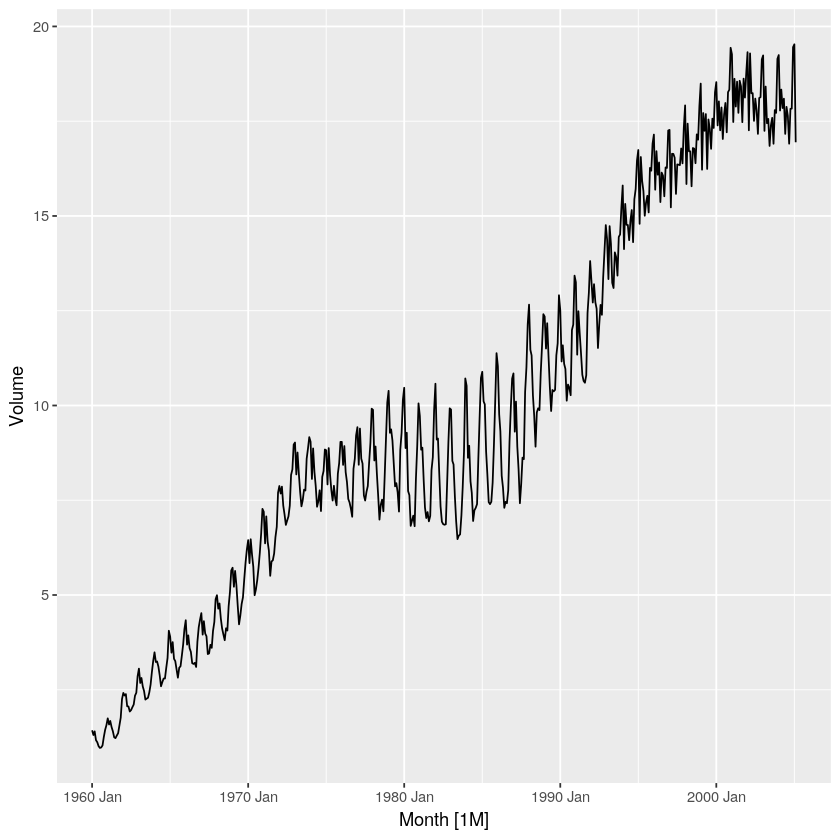

In [41]:
canadian_gas %>%
    autoplot(Volume)

`gg_subseries()`

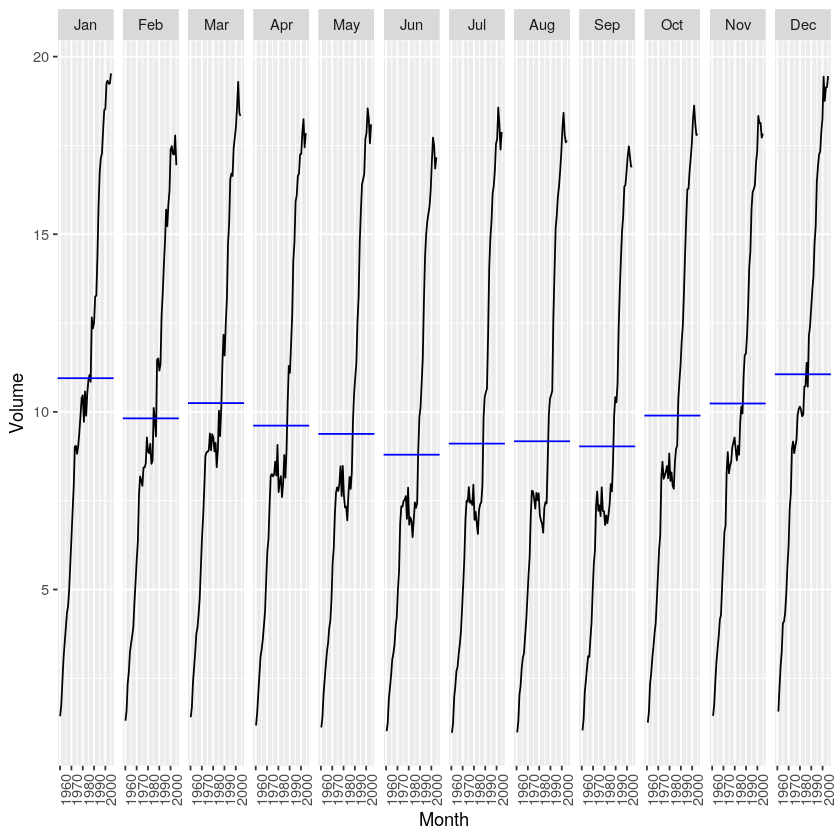

In [42]:
canadian_gas %>%
    gg_subseries(Volume)

`gg_season()`

Warning message in NextMethod("["):
“Incompatible methods (">=.Date", ">=.vctrs_vctr") for ">="”Warning message in NextMethod("["):
“Incompatible methods ("<=.Date", "<=.vctrs_vctr") for "<="”Warning message in NextMethod("["):
“Incompatible methods (">=.Date", ">=.vctrs_vctr") for ">="”Warning message in NextMethod("["):
“Incompatible methods ("<=.Date", "<=.vctrs_vctr") for "<="”

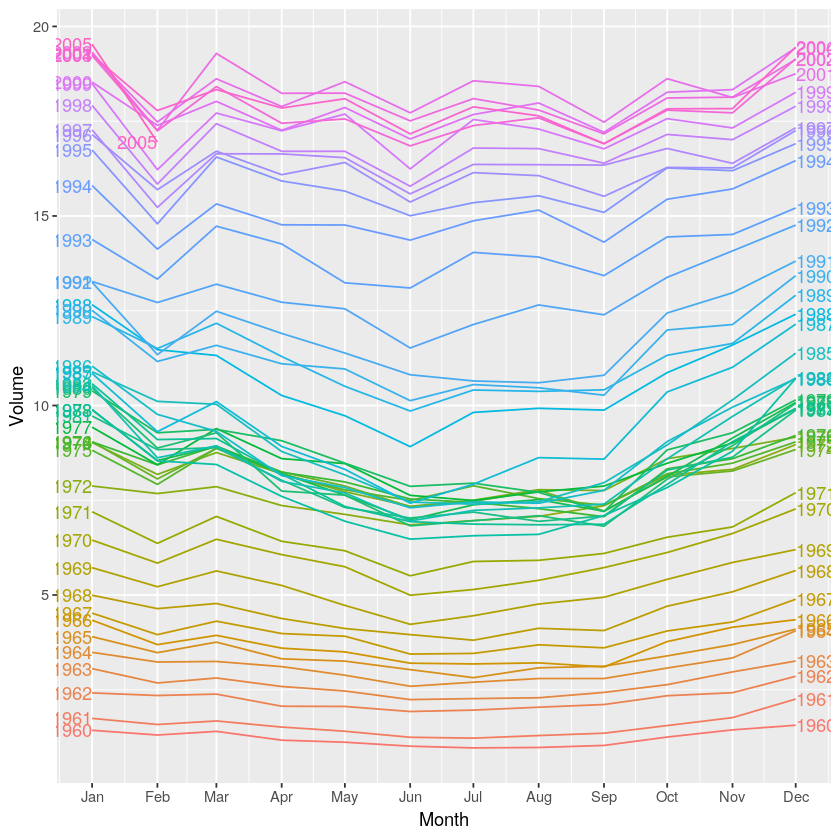

In [43]:
canadian_gas %>%
    gg_season(Volume, labels="both")

## b.

In [44]:
#I chose the default values for monthly data
stl_dcmp <- canadian_gas %>%
  model(
    STL(Volume ~ trend(window = 21) +
                   season(window = 13),
    robust = TRUE))

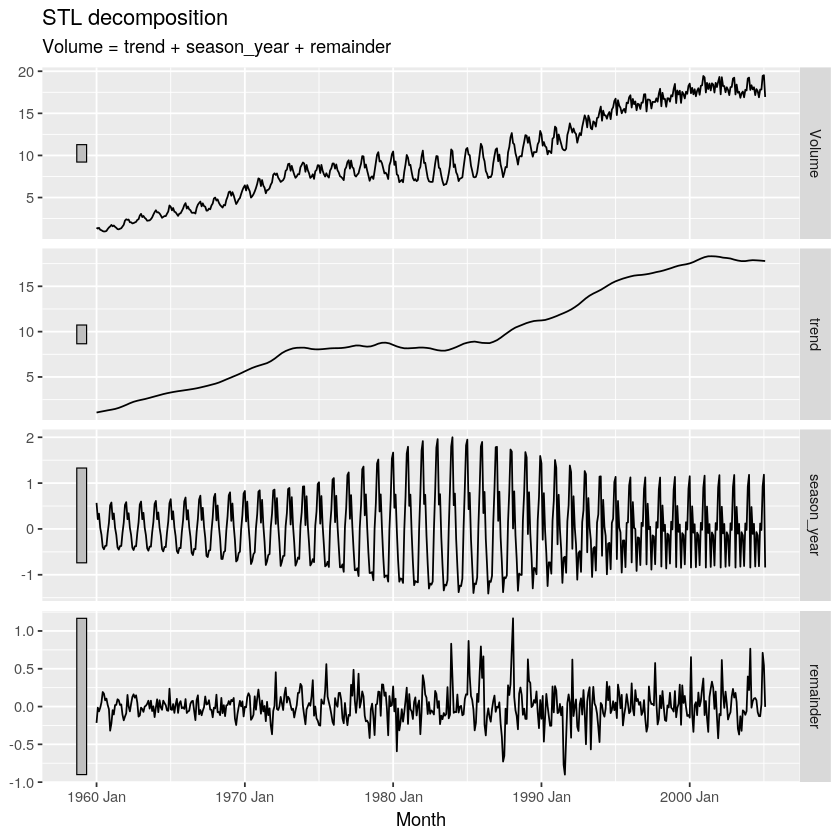

In [45]:
stl_dcmp %>%
    components() %>%
    autoplot()

## c.

Warning message in NextMethod("["):
“Incompatible methods (">=.Date", ">=.vctrs_vctr") for ">="”Warning message in NextMethod("["):
“Incompatible methods ("<=.Date", "<=.vctrs_vctr") for "<="”Warning message in NextMethod("["):
“Incompatible methods (">=.Date", ">=.vctrs_vctr") for ">="”Warning message in NextMethod("["):
“Incompatible methods ("<=.Date", "<=.vctrs_vctr") for "<="”

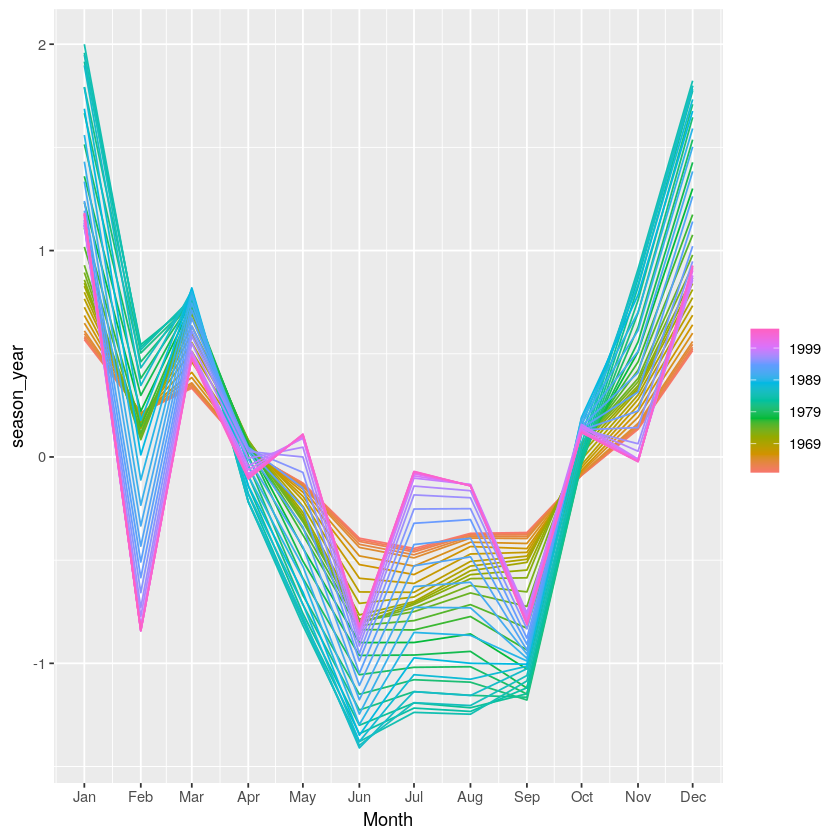

In [46]:
components(stl_dcmp) %>%
    gg_season(season_year)

It takes a little bit of time to notice, but we can see that the original seasonal shape started off much smoother in the beginning (evidenced by the dark orange series and it's neighbours), then began a transition period before reaching a new seasonal pattern that, while it does fall then rise throughout the year, tends to have many more peaks and valleys.

To see how the seasonal shape has changed over the long run and ignoring the transition period, first look at the dark orange series, then the dark magenta series. You can see how they are different and if you look harder, you can even see how one transitioned into the other over time.

## d.

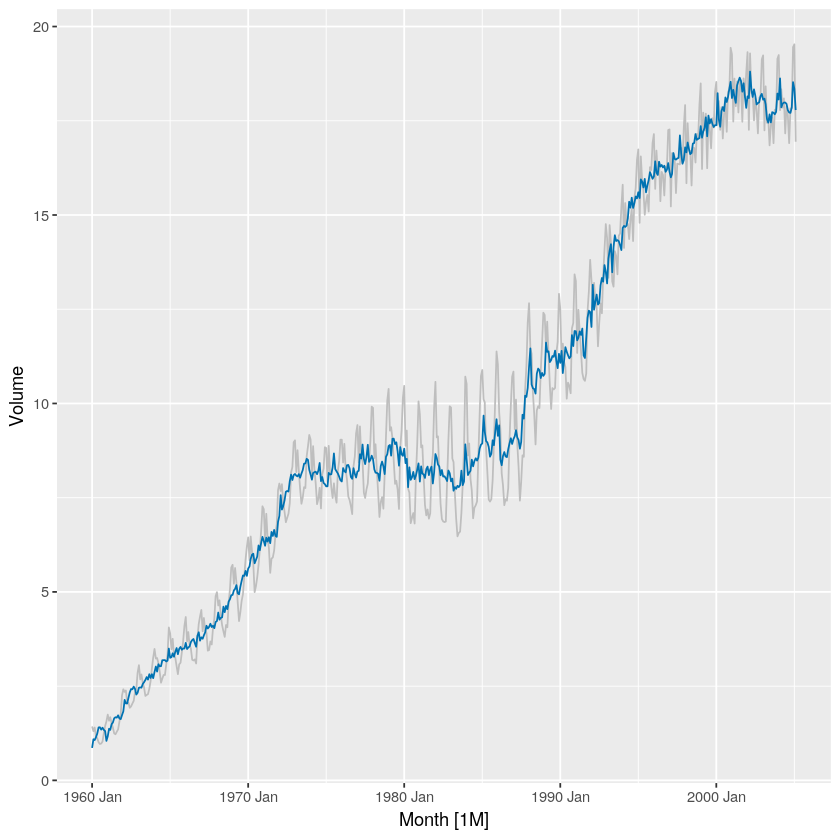

In [47]:
components(stl_dcmp) %>%
    as_tsibble() %>%
    autoplot(Volume, colour = "gray") + 
    geom_line(aes(y=season_adjust), colour = "#0072B2")

I think yes. The above plot seems pretty plausible.

## e.

Uforturnately, I won't be answering this question. The installation and setup needed to be able to use X-11 or SEATS via X_13ARIMA_SEATS is quite complicated and requires the use of packages not covered in this book.